# Counterfactual instances on MNIST

Requirements
- Python 3.10
- `pip install alibi[tensorflow]`

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

c:\Users\xmors\Desktop\counterfactuals\alibi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TF version:  2.14.1
Eager execution enabled:  False


## Load MNIST data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


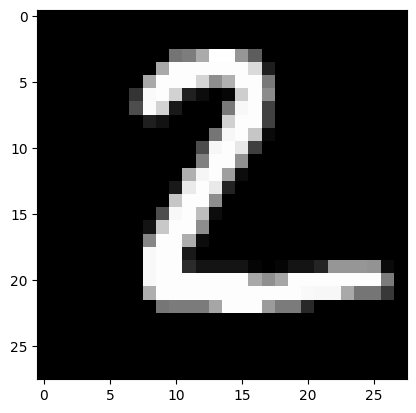

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [5]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Black-box model

### Train CNN model

In [6]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [7]:
cnn_path = os.path.join("models", "alibi", "mnist")
cnn_model_path = os.path.join(cnn_path, "cnn_mnist.h5")

In [8]:
if not os.path.exists(cnn_path):
    os.makedirs(cnn_path)

In [9]:
if not os.path.exists(cnn_model_path):
    cnn = cnn_model()
    cnn.summary()
    cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
    cnn.save(cnn_model_path)
else:
    cnn = load_model(cnn_model_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                        

c:\Users\xmors\Desktop\counterfactuals\alibi\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

c:\Users\xmors\Desktop\counterfactuals\alibi\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy:  0.986


## Generate counterfactuals

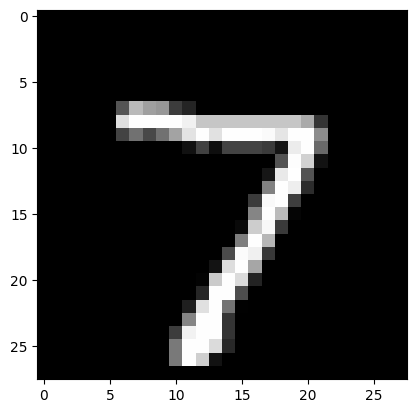

In [11]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

In [12]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

In [13]:
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

c:\Users\xmors\Desktop\counterfactuals\alibi\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Explanation took 6.703 sec


Counterfactual prediction: 3 with probability 0.9910854697227478


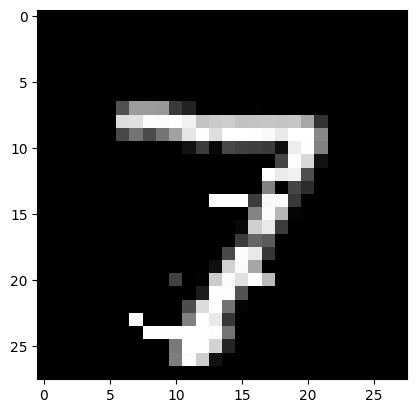

In [14]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

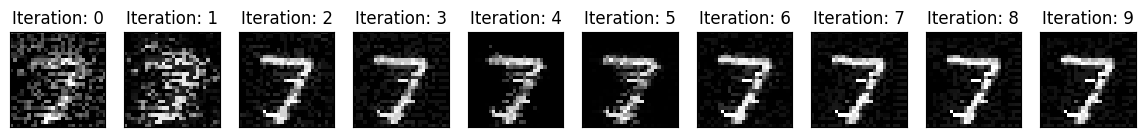

In [15]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

In [16]:
target_class = 1

cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 4.600 sec


Counterfactual prediction: 1 with probability 0.9993383288383484


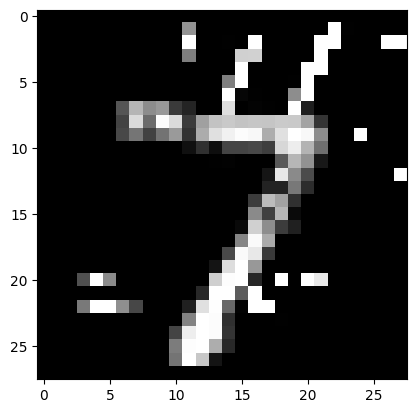

In [17]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

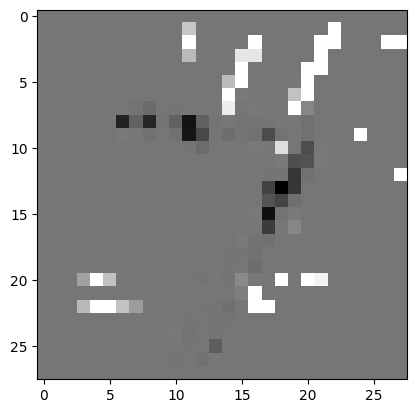

In [18]:
plt.imshow((explanation.cf['X'] - X).reshape(28, 28));

# Counterfactuals guided by prototypes on MNIST

In [26]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import CounterfactualProto

## Black-box model

### Train auto-encoder

In [27]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

In [28]:
ae_path = os.path.join("models", "alibi", "mnist")
ae_model_path = os.path.join(ae_path, "ae_mnist.h5")
enc_model_path = os.path.join(ae_path, "enc_mnist.h5")

In [29]:
if not os.path.exists(ae_path):
    os.makedirs(ae_path)

In [30]:
if not os.path.exists(ae_model_path):
    ae, enc, dec = ae_model()
    ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
    ae.save(ae_model_path, save_format='h5')
    enc.save(enc_model_path, save_format='h5')
else:
    ae = load_model(ae_model_path)
    enc = load_model(enc_model_path, compile=False)

c:\Users\xmors\Desktop\counterfactuals\alibi\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
c:\Users\xmors\Desktop\counterfactuals\alibi\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


c:\Users\xmors\Desktop\counterfactuals\alibi\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


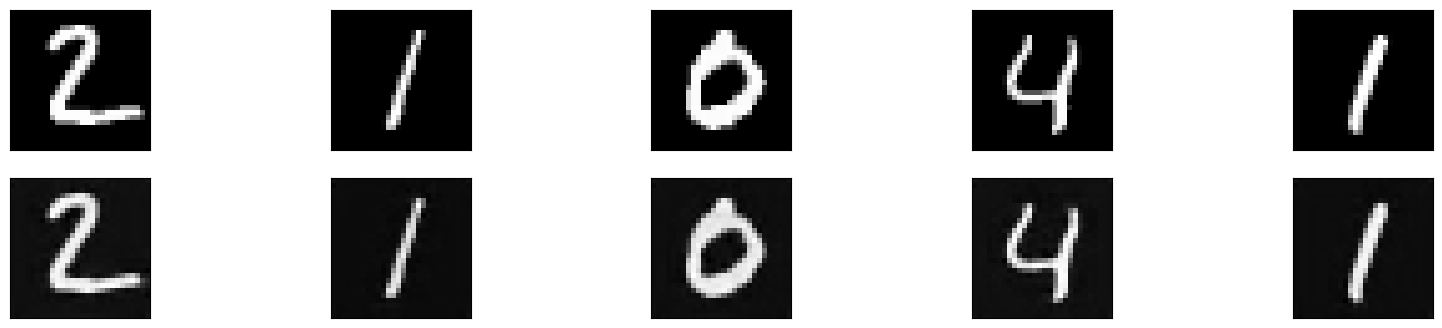

In [31]:
decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generate counterfactual guided by the nearest class prototype

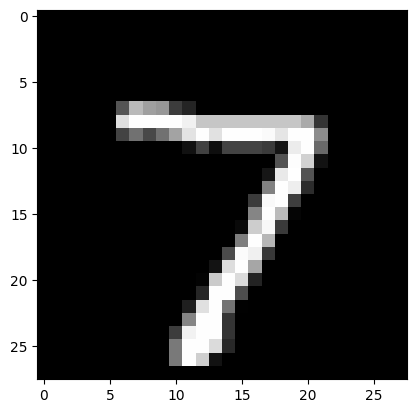

In [32]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

In [33]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

In [34]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 12.900 sec
Explanation took 5.477 sec


Counterfactual prediction: 9
Closest prototype class: 9


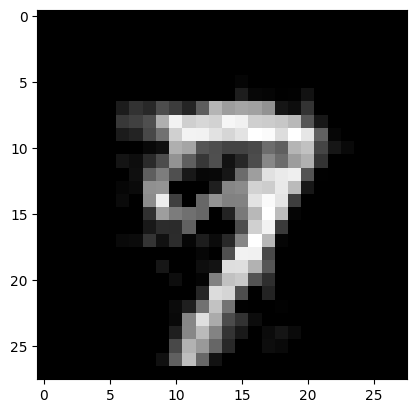

In [35]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

iteration c 0


C:\Users\xmors\AppData\Local\Temp\ipykernel_5672\1631250178.py:3: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  n = len(explanation['all'][iter_cf])
C:\Users\xmors\AppData\Local\Temp\ipykernel_5672\1631250178.py:7: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28))


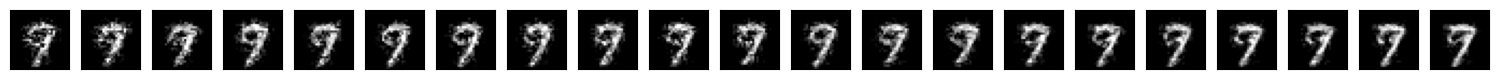

In [36]:
iter_cf = 0
print(f'iteration c {iter_cf}')
n = len(explanation['all'][iter_cf])
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n+1, i+1)
    plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Prototypes defined by the `k` nearest encoded instances

In [37]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_k1 = cf.explain(X, k=1, k_type='mean')
explanation_k20 = cf.explain(X, k=20, k_type='mean')

Counterfactual prediction: 9
Closest prototype class: 9


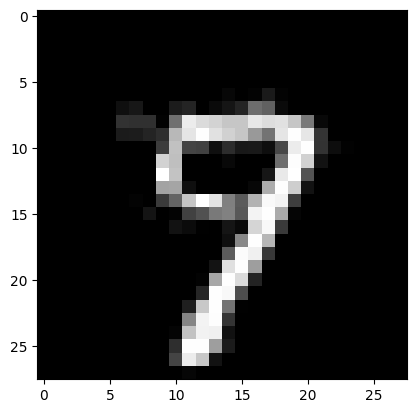

In [38]:
print('Counterfactual prediction: {}'.format(explanation_k1.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k1.cf['X'].reshape(28, 28));

Counterfactual prediction: 9
Closest prototype class: 9


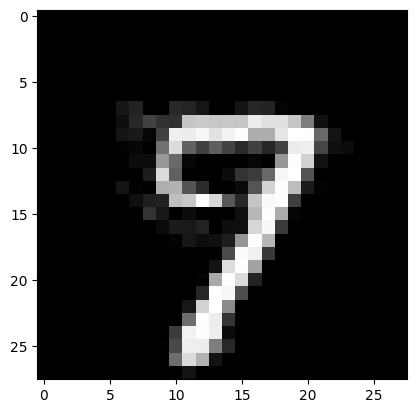

In [39]:
print('Counterfactual prediction: {}'.format(explanation_k20.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k20.cf['X'].reshape(28, 28));

### Remove the autoencoder loss term `L_AE`

In [40]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 4.576 sec


Counterfactual prediction: 9
Closest prototype class: 9


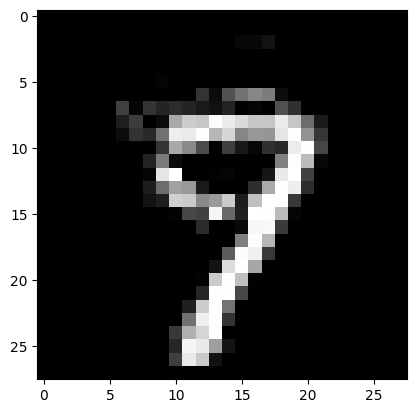

In [41]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

### Specify prototype classes

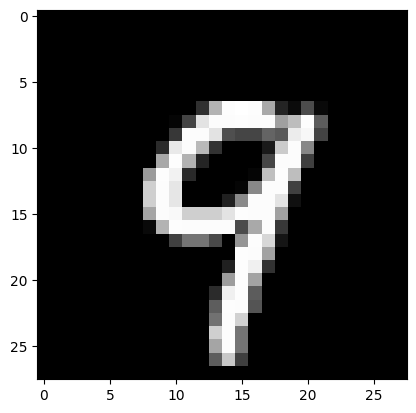

In [42]:
X = x_test[12].reshape((1,) + x_test[1].shape)
plt.imshow(X.reshape(28, 28));

In [43]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_1 = cf.explain(X, k=5, k_type='mean')
proto_1 = explanation_1.id_proto
explanation_2 = cf.explain(X, k=5, k_type='mean', target_class=[7])
proto_2 = explanation_2.id_proto

Counterfactual prediction: 4
Closest prototype class: 4


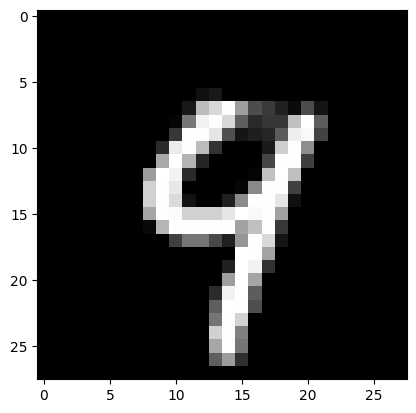

In [44]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print(f'Closest prototype class: {proto_1}')
plt.imshow(explanation_1.cf['X'].reshape(28, 28));

Counterfactual prediction: 7
Closest prototype class: 7


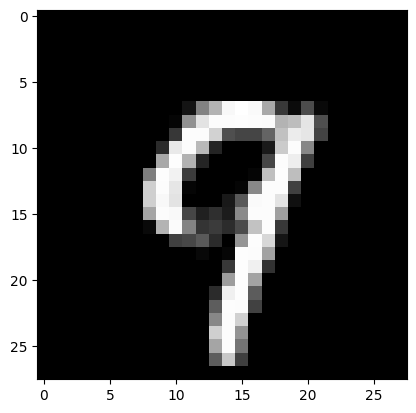

In [45]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print(f'Closest prototype class: {proto_2}')
plt.imshow(explanation_2.cf['X'].reshape(28, 28));